# Credit Default Modelling

This Jupyter notebook increments a base line model performance (**i.e. Logistic Regression initial model**) over a credit default dataset. Therefore, this notebook is specifiacally designed for financial and mathematical analyst in the *credit risk assessment financial industry*.

The problem that we are going to solve is a **binary classification problem**: *is our new client going to default ?*

The whole notebook is divided accorsing to the following sections:

1. **[Service factory](#service_factory)**: 

    This is a collection of functions that are multiple times used all over the notebook. The good thing about it is that *they are portable*: any coder that will be cut and pasting this notebook can re-adapt the to his/her needs.<br><br>

2. **[Exploratory data analysis](#eda)**: 

    Understanding the *business underlying objective is important* as much as good modelling. Therefore, we must code EDA first. In this part of the notebook we can see, firstly, the main datatypes and the presence of missing values and, secondly, the different impact of categorical and numerical variables over the label we would like to predict (i.e. default). 
    
    Within this section we perform **balancing among SMOTE, oversampling and undersampling.** The objective here is to use a single dataset in which the minority class (i.e. the client defaulted) will be having the same weight" in the dataset (i.e. 50% among both of the two classes, default and not-default)<br><br>

3. **[Model Selection](#model_selection)**: 

    We have been comparing different models (*Logistic Regression, Random Forest, Naive Bayes, Boosting Machines, SVM and kNN*) to see which one performs best. **All the models follow the same exploration pattern** which is:
    >- define and *objective* function and a *parameters optimisation space*
    >- perform Bayes Optimisation with best parameters found previously
    >- fit and predict on our specific model (e.g. Logistic Regression)
    >- calculate and plot performance report 
<br>

4. **[Conclusions](#conclusions)**:
<br>

5. **[Appendix](#appendix)**: 

    In this notebook we have performed models *one after the other*. We would like to shocase a *lazy* but less customizable approach for the curious reader to explore !
<br>

***

### Service Factory <a class="anchor" id="service_factory"></a>

In [3]:
# Create general contants and overall warning disabling together with general required packages installation.

import os
import warnings
import pandas as pd
import numpy as np
warnings.filterwarnings("ignore")

##################################
# Costants all over the notebook
RANDOM_STATE = 999
TEST_SIZE    = 0.25
BAYES_LOOPS  = 10
MAIN_PATH    = os.getcwd()
##################################

## Uncomment the following line to install all the packages used in this notebook.
# import sys
# !{sys.executable} -m pip install numpy pandas matplotlib seaborn xlrd lazypredict
# !{sys.executable} -m pip install networkx --force-reinstall --no-deps --upgrade --user
# !{sys.executable} -m pip install hyperopt

In [4]:
def standar_scaler(X_train:None, X_test:None):
    
    '''
    This function performs a critical step: standard scaling of the dataset before perfrominng any modelling.
    '''
    
    if X_train is None or X_test is None:
        raise Exception("Sorry, all the paramters to standar_scaler function !") 
    
    scaler         = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled

In [5]:
def get_auc_and_plot_roc(y_test:None, y_pred_proba:None, model_name:None):
    
    '''
    This function simply plot ROC curve given:
    - y_test:       y test datasplit
    - y_pred_proba: y test probabilities out of the model
    - model_name:   the name of the model we are plottign the ROC curve about
    '''
    
    if y_test is None or y_pred_proba is None or model_name is None:
        raise Exception("Sorry, all the paramters to plot_roc function !") 
    
    auc = roc_auc_score(y_test, y_pred_proba)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr, label = '' + model_name + ' (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
    
    return auc

In [6]:
def get_and_display_performance_metrics(y_test:None, y_pred:None):
    
    '''
    This function is easy: given the y_test and its predictions it print to the console model overall performance.
    Pay attention to import all the sklearn dedicated functions here below before calling this function.
    '''
    
    if y_test is None or y_pred is None:
        raise Exception("Sorry, pass both y_test and y_pred to the function.") 
    
    acc   = accuracy_score(y_test, y_pred)
    cm    = confusion_matrix(y_test, y_pred)
    cr    = classification_report(y_test, y_pred)
    cr_d  = classification_report(y_test, y_pred, output_dict=True)
    
    print("Best Hyperparameters:", best_params, '\n')
    print("Accuracy Score:", acc, '\n')
    print("Confusion Matrix:")
    print(cm, '\n')
    print("Classification Report:")
    print(cr)
    
    return acc, cm, cr_d

In [7]:
def split_test_train_for_all(data_to_split:pd.DataFrame = None, label_to_predict:str = 'default'):
    
    '''
    This function, given a dataframe and a label to predict, split the dataset into train and test sub
    datasets. We are going to use this function to let all the models reason on the same exact datasets.
    '''
    
    if data_to_split is None:
        raise Exception("Sorry, pass a DataFrame to split in train and test data.") 
    
    X = data_to_split.drop(label_to_predict, axis=1)
    y = data_to_split[label_to_predict]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, random_state = RANDOM_STATE)
    
    return X_train, X_test, y_train, y_test

In [75]:
def plot_hbar_perf_comparison(title, y_pos, performance, color, model) -> None:
    
    fig, ax = plt.subplots()
    ax.barh(y_pos, performance, align='center', edgecolor='black', color=color)
    ax.set_yticks(y_pos, labels=model['models'])
    ax.invert_yaxis()
    ax.set_xlabel('Performance')
    ax.set_title(title)
    
    return None

***

### Exploratory data analysis (EDA) <a class="anchor" id="eda"></a>

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
os.chdir('..')
print(f'Main path for this project is {os.getcwd()}')

Main path for this project is /Users/andrea/Documents/Github Repositories/Capstone


In [10]:
# Import the data and perform EDA

credit_data = pd.read_csv('./data/UCI_Credit_Card.csv', sep=',')
credit_data = credit_data.rename(columns = {'default.payment.next.month':'default'})

In [11]:
# Before we even begin, let's see the datatypes of our data and its types...

credit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         30000 non-null  int64  
 1   LIMIT_BAL  30000 non-null  float64
 2   SEX        30000 non-null  int64  
 3   EDUCATION  30000 non-null  int64  
 4   MARRIAGE   30000 non-null  int64  
 5   AGE        30000 non-null  int64  
 6   PAY_0      30000 non-null  int64  
 7   PAY_2      30000 non-null  int64  
 8   PAY_3      30000 non-null  int64  
 9   PAY_4      30000 non-null  int64  
 10  PAY_5      30000 non-null  int64  
 11  PAY_6      30000 non-null  int64  
 12  BILL_AMT1  30000 non-null  float64
 13  BILL_AMT2  30000 non-null  float64
 14  BILL_AMT3  30000 non-null  float64
 15  BILL_AMT4  30000 non-null  float64
 16  BILL_AMT5  30000 non-null  float64
 17  BILL_AMT6  30000 non-null  float64
 18  PAY_AMT1   30000 non-null  float64
 19  PAY_AMT2   30000 non-null  float64
 20  PAY_AM

In [12]:
# Before we even continue, let's spot possible missing data to then manage them...
# ...in pandas is just one line of code !

credit_data.isnull().sum()

ID           0
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
default      0
dtype: int64

In [13]:
# Overall, we are speaking about this dataframe:

credit_data.head(3)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0


There are no missing datapoints so we will be not performing any missing data management as shown [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3668100/).

*After* initial missing data and types exploration is performed, we can do some basic *Statistics and Correlations* as follows:

1. we displayed the **basic statistics** of all the features using data.describe().
2. we visualized the **correlation matrix** using a heatmap to understand the relationships between different features.

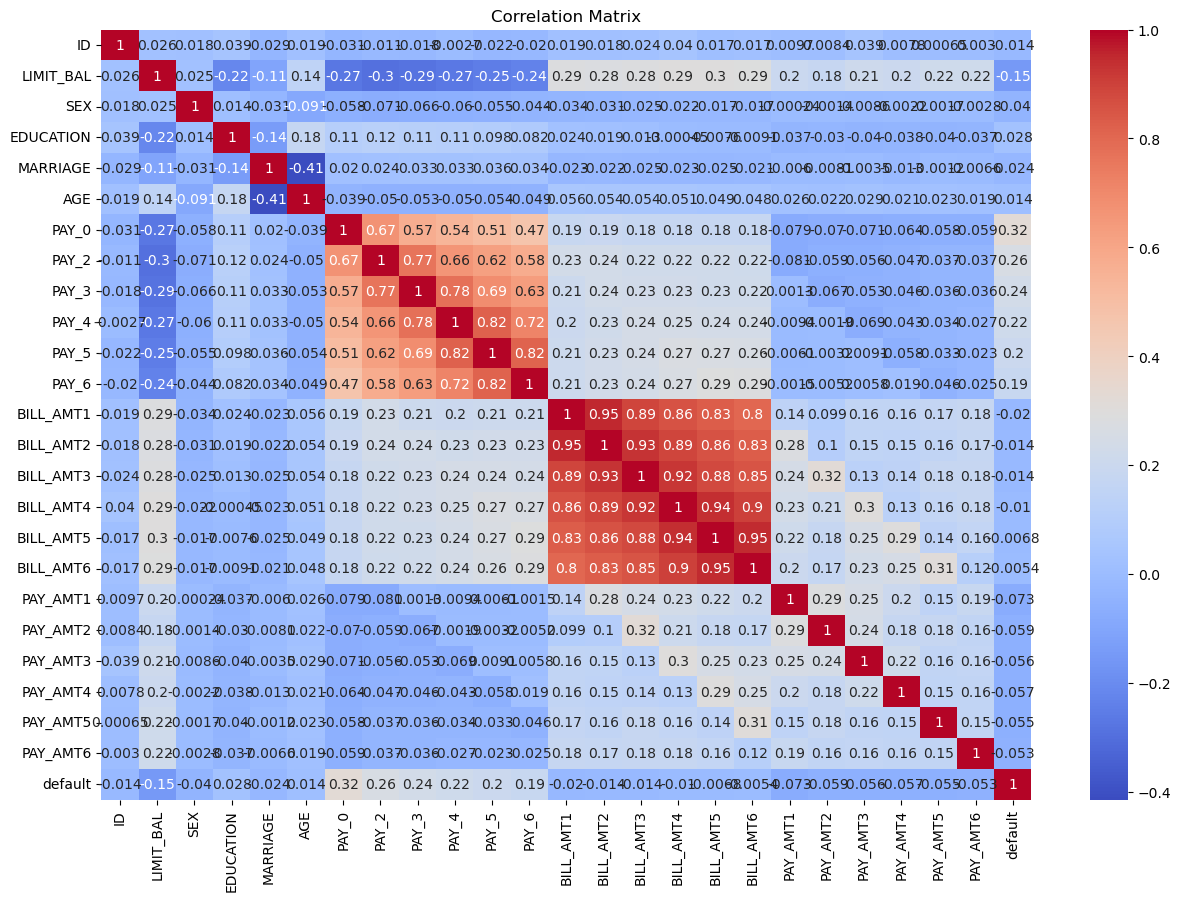

In [14]:
# 1. Let's perform some correlations to spot if there are hidden association under the hood...

#print(credit_data.describe())

plt.figure(figsize=(15, 10))
sns.heatmap(credit_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

We are supposed to have a distribution of Numerical Features now by **plotting histograms for all the numerical features to visualize their distributions, just as follows.***

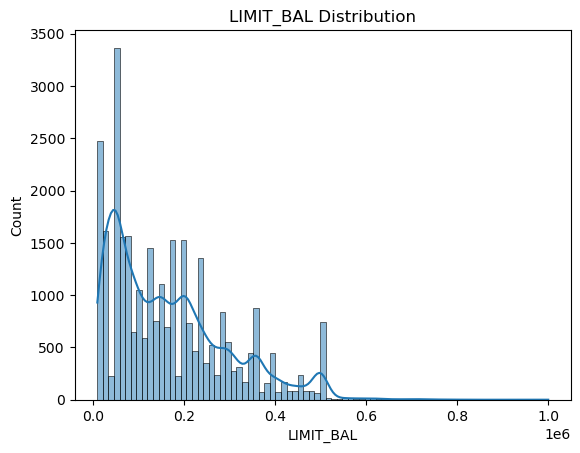

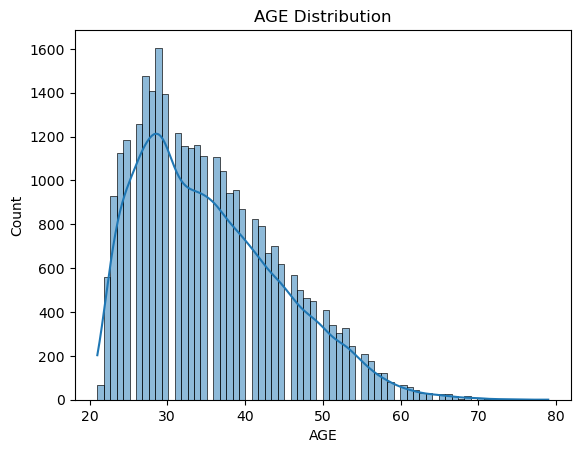

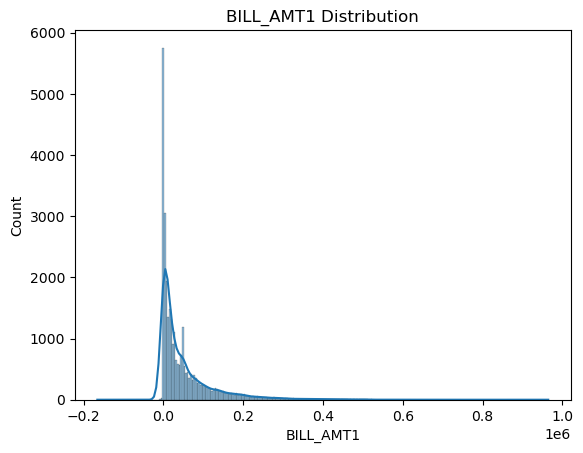

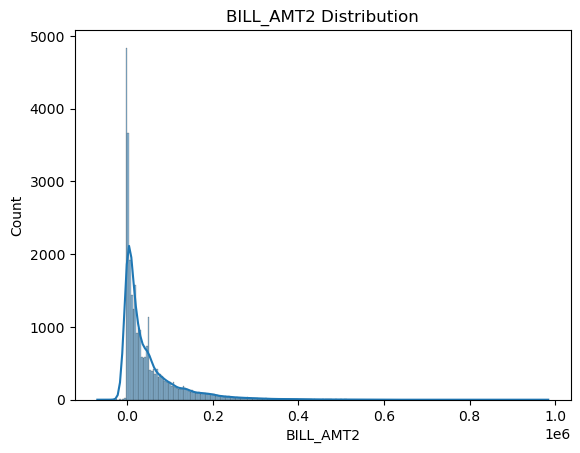

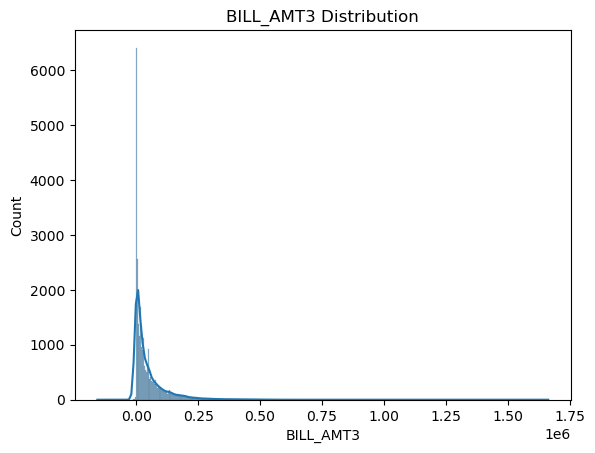

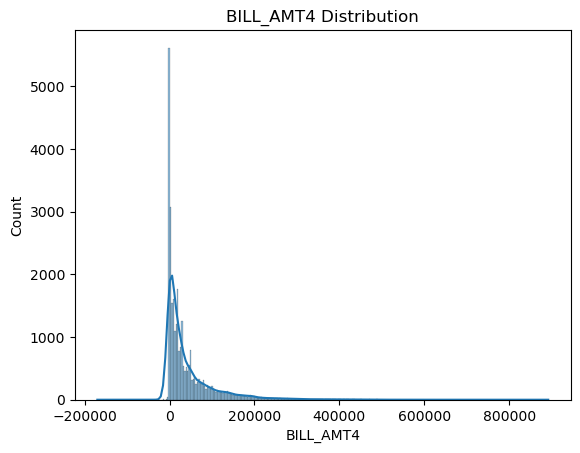

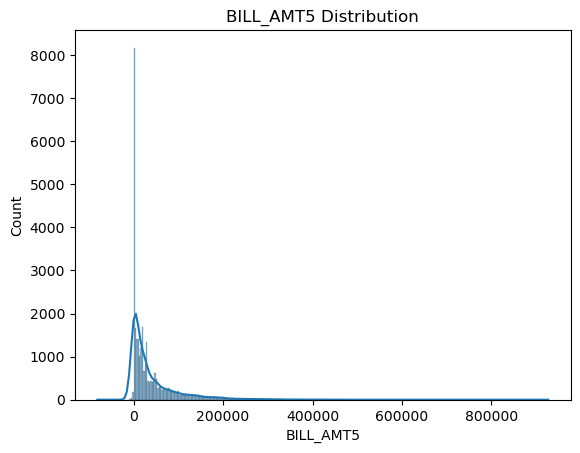

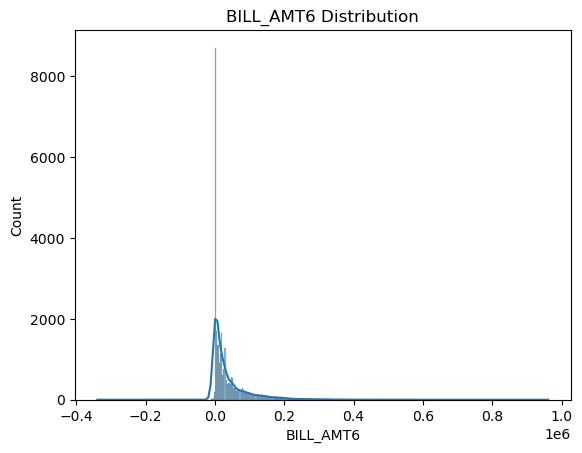

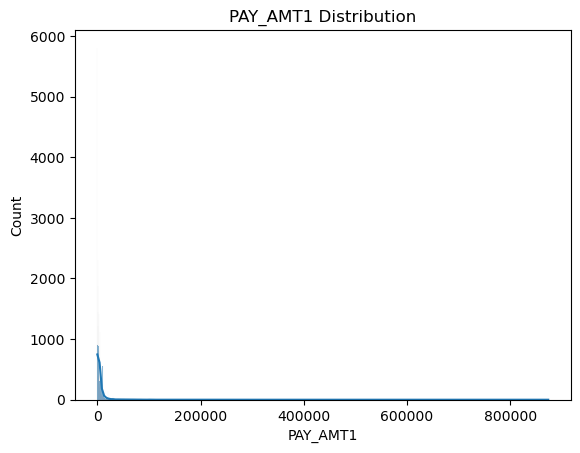

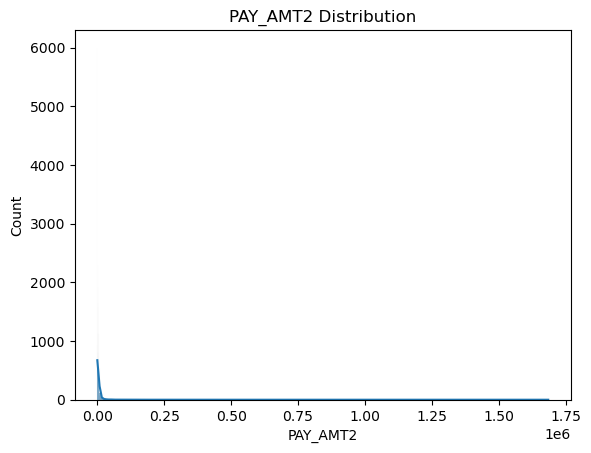

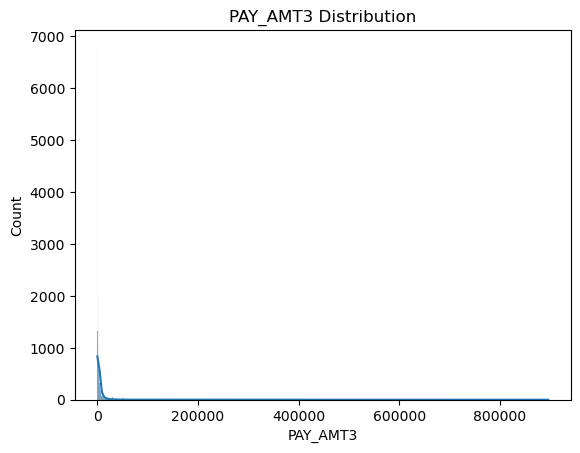

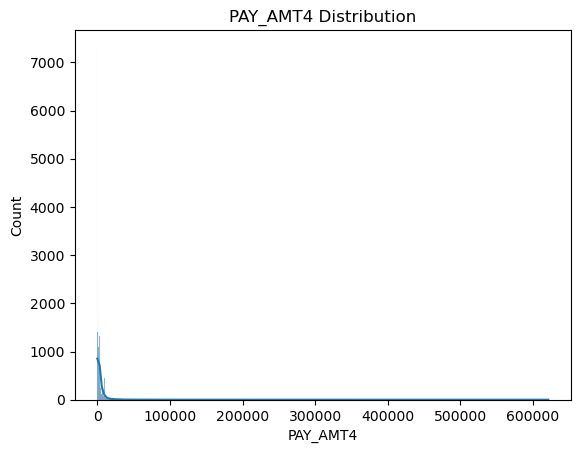

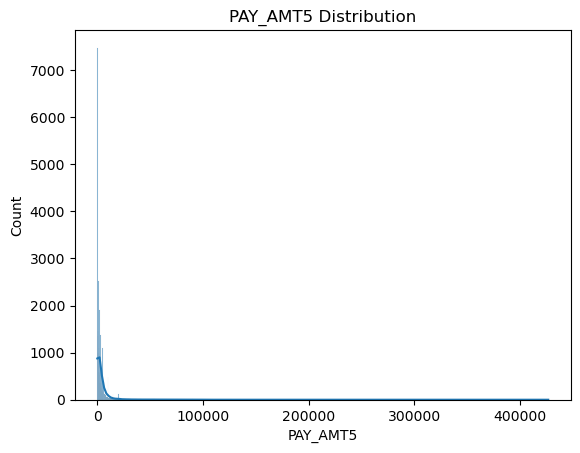

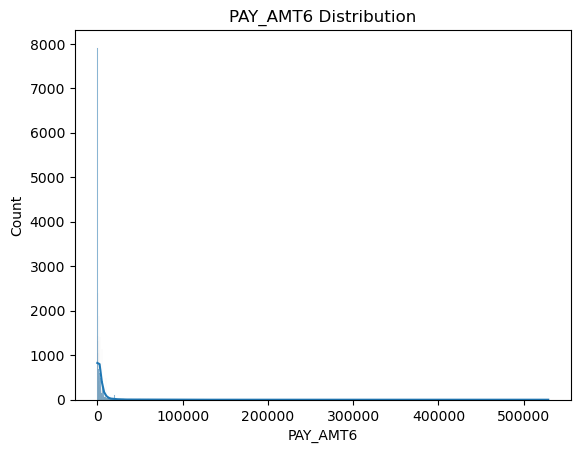

In [15]:
# 2. Let's visualise the distribution of all the numerical features...

numerical_features = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 
                      'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

for feature in numerical_features:
    
    plt.figure()
    sns.histplot(credit_data[feature], kde=True)
    plt.title(f'{feature} Distribution')
    plt.show()

As we did for numerical features, we perform the same over categorical features with count plots just *using count plots for all the categorical features to visualize the count of each category in the features.*

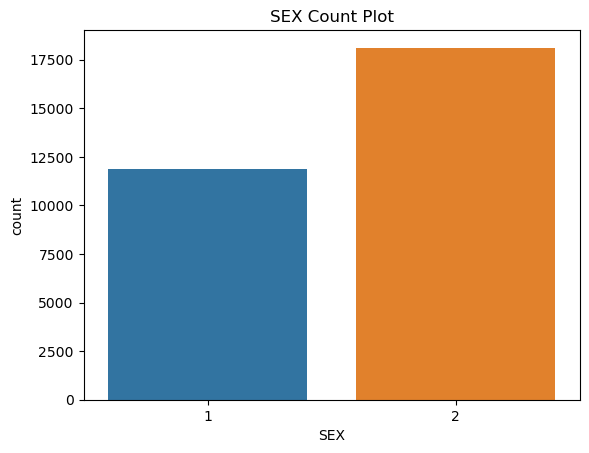

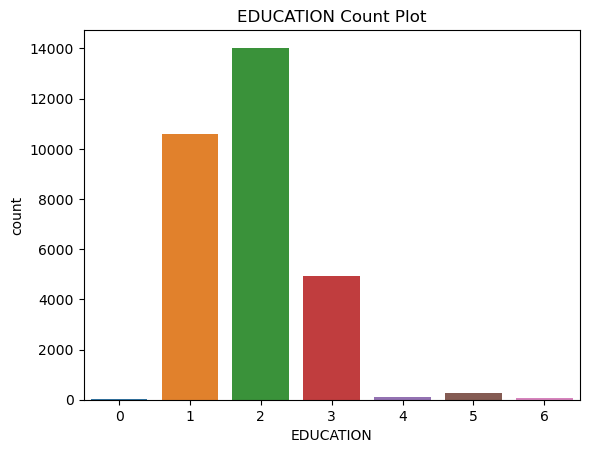

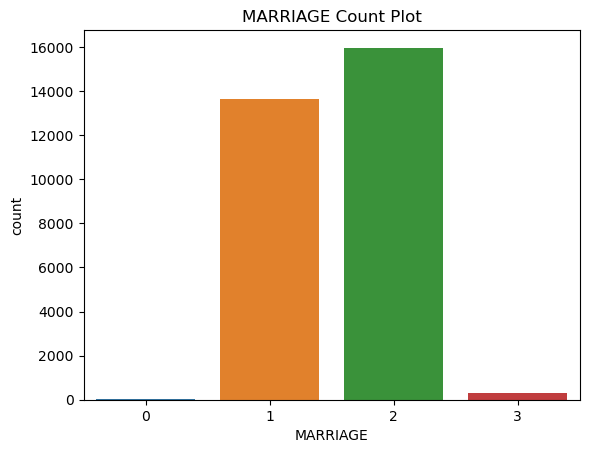

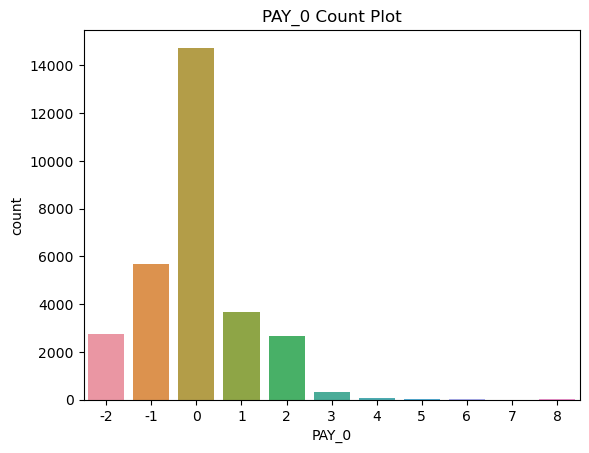

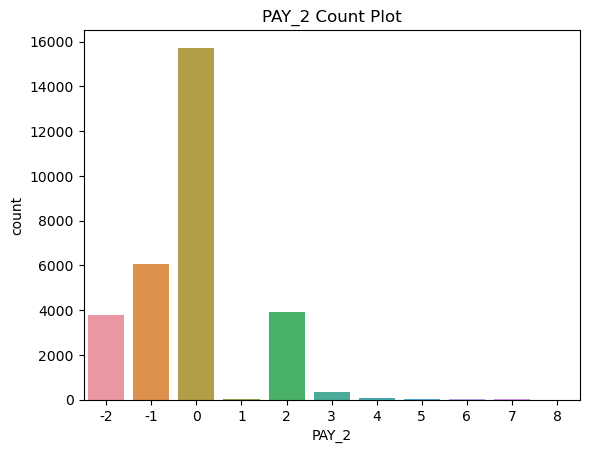

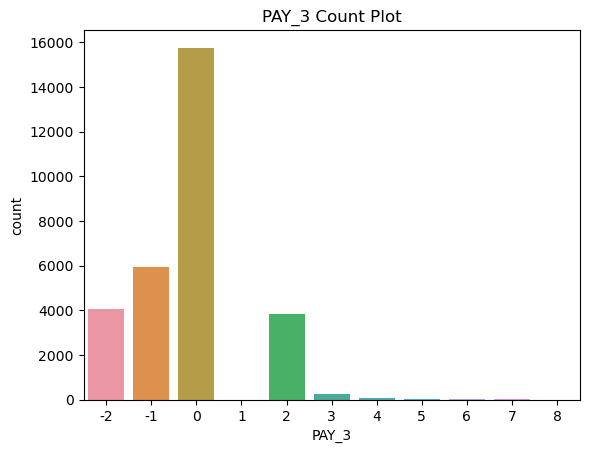

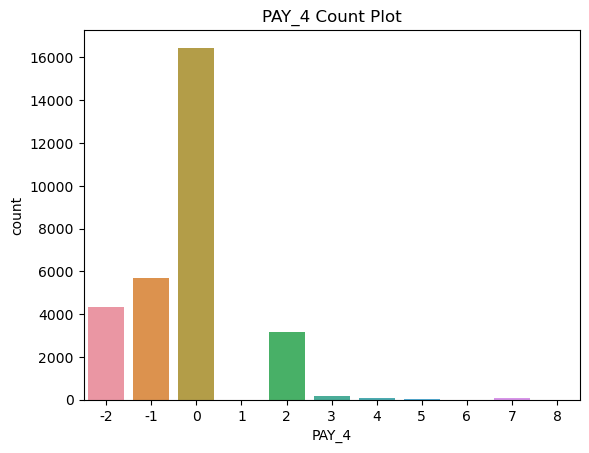

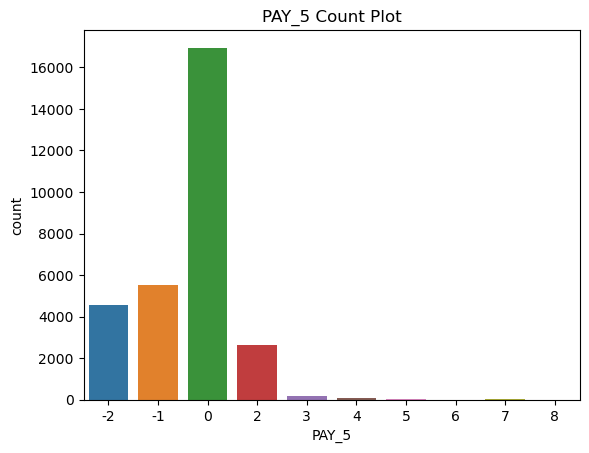

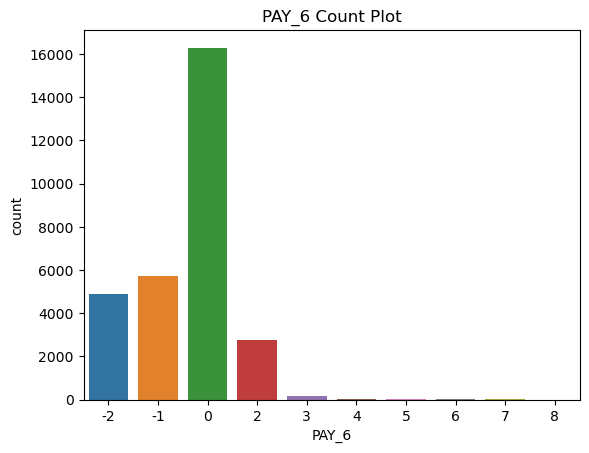

In [16]:
# 3. Let's visualise the distribution of all the numerical features...

categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

for feature in categorical_features:
    
    plt.figure()
    sns.countplot(x=feature, data=credit_data)
    plt.title(f'{feature} Count Plot')
    plt.show()

We know investigate over *Default Rates Across Different Categories*. <br>
To do so, we do bar plots to **visualize the default rates across different categories** in the categorical features just as follows:

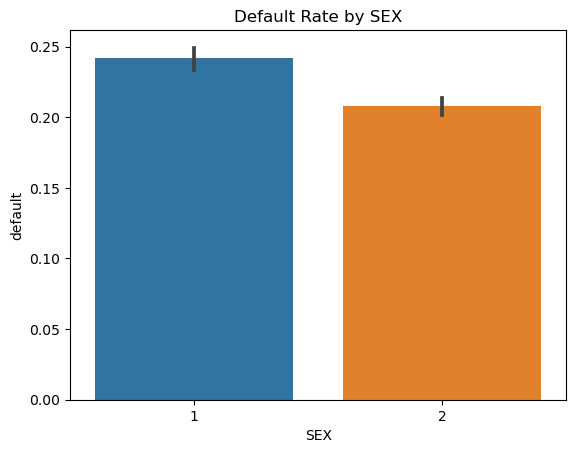

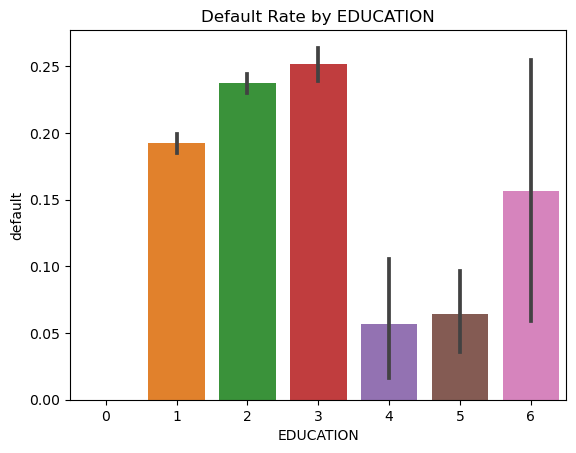

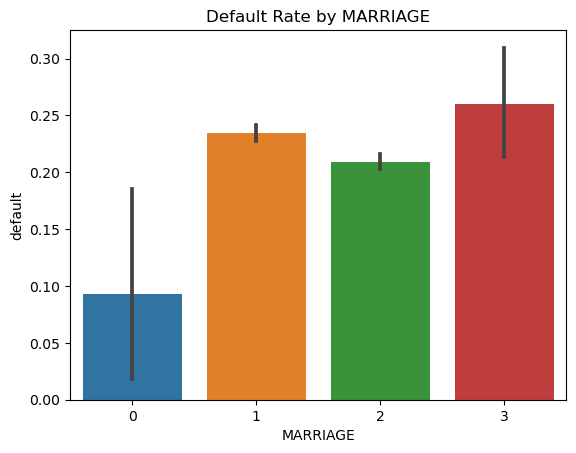

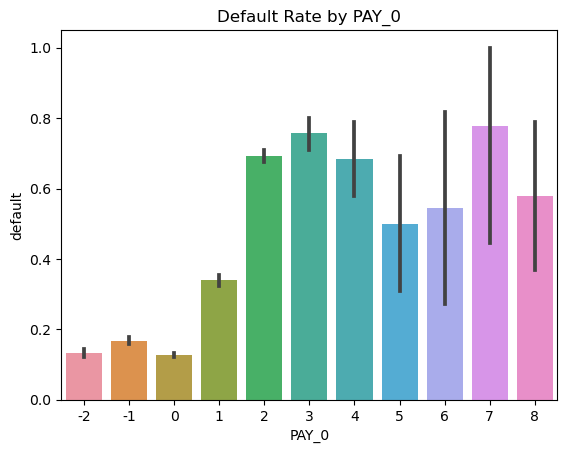

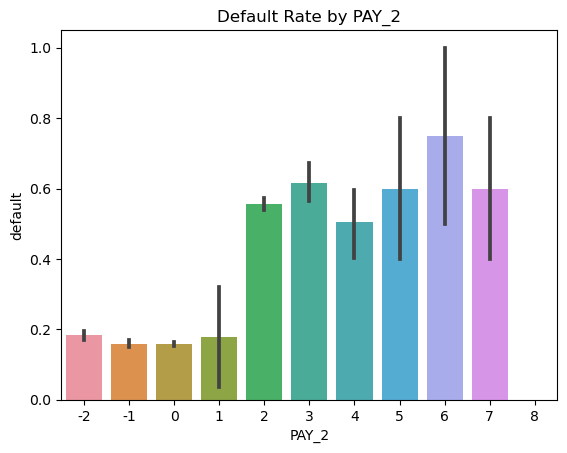

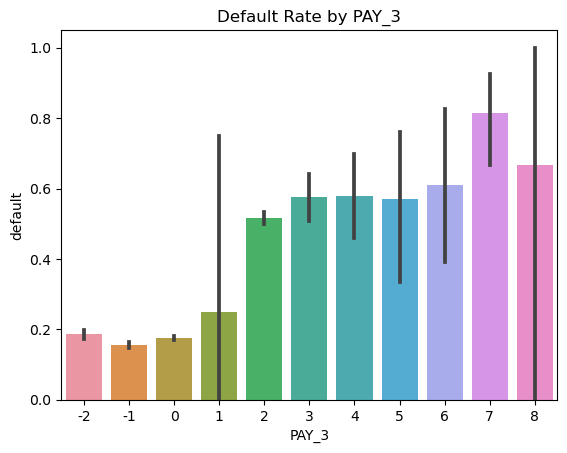

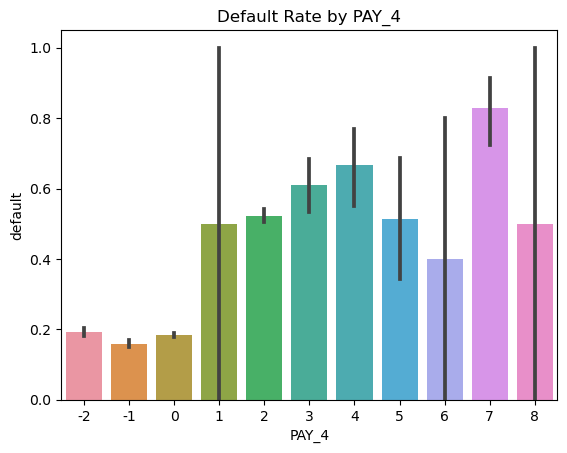

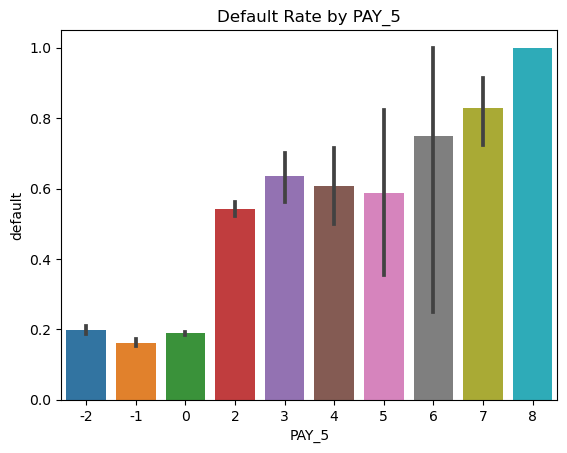

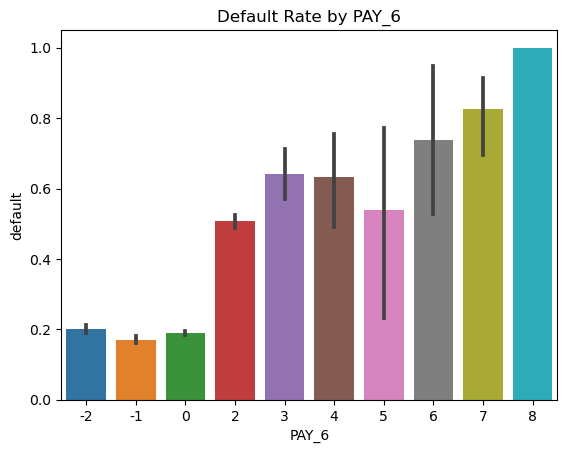

In [17]:
# 4. Let's visualise the distribution of the default rates across different categories...

for feature in categorical_features:
    
    plt.figure()
    sns.barplot(x=feature, y='default', data=credit_data)
    plt.title(f'Default Rate by {feature}')
    plt.show()

We can perform one last analysis now: **we plot a pair plot for a subset of variables to visualize the relationships between them and how they are affected by the target variable ('default').**

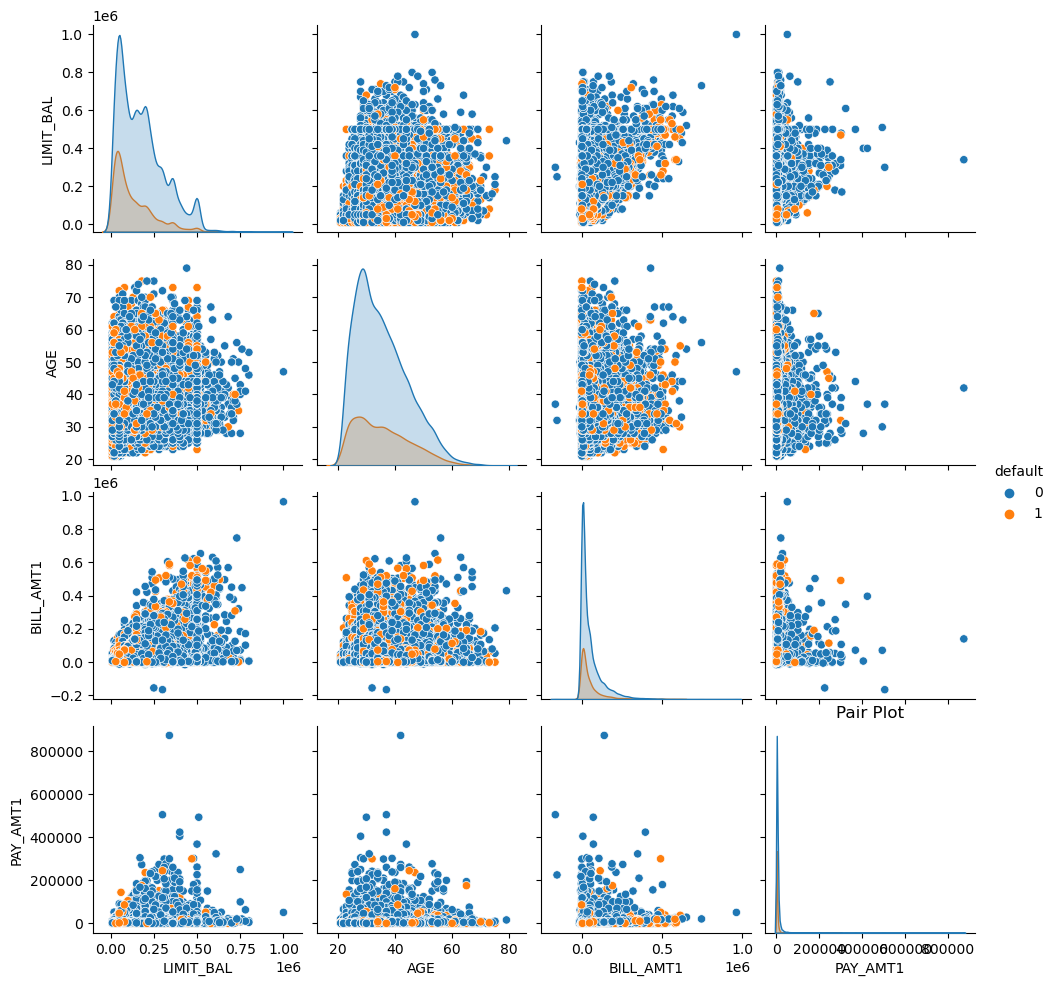

In [18]:
# 5. Let's visualise the pair plot for a subset of variables to visualize relationships

sns.pairplot(credit_data[['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'PAY_AMT1', 'default']], hue='default')
plt.title('Pair Plot')
plt.show()

We must now keep an eye on the nature of how much this **dataset is balanced (or not)***.

In [19]:
# 6. The problem we're are going to solve is imbalanced: let's see how much it is imbalanced

credit_data['default'].value_counts(normalize=True)

default
0    0.7788
1    0.2212
Name: proportion, dtype: float64

We see that the **77.88% of our data is about good payers while the remaining is about "defaulters"**. <br>
Since our dataset has 30,000 observations, it means we have 6636 bad payers in out data.

Our dataset is not that imbalanced as we could have been thinking at the benigging which means, under a business point of view, that the institution that has this dataset has lots of bad payers ! <br>

In order to be accurate in out predictions, we are going to leverage the following tecniques to balance this dataset:

1. [SMOTE](https://learn.microsoft.com/en-us/azure/machine-learning/component-reference/smote?view=azureml-api-2)
2. [Oversampling](https://en.wikipedia.org/wiki/Oversampling)
3. [Undersampling](https://en.wikipedia.org/wiki/Undersampling)

As follows the code to do so.

In [20]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [21]:
# Split the data into training and testing sets

X = credit_data.drop('default', axis=1)
y = credit_data['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [22]:
# Apply SMOTE...

smote            = SMOTE(random_state=RANDOM_STATE)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

print(f'SMOTE shape is {X_smote.shape}')
y_smote.value_counts()

SMOTE shape is (37452, 24)


default
0    18726
1    18726
Name: count, dtype: int64

In [23]:
# Apply OVERSAMPLING...

oversampler                  = RandomOverSampler(random_state=RANDOM_STATE)
X_oversampled, y_oversampled = oversampler.fit_resample(X_train, y_train)

print(f'Oversampled shape is {X_oversampled.shape}')
y_oversampled.value_counts()

Oversampled shape is (37452, 24)


default
0    18726
1    18726
Name: count, dtype: int64

In [24]:
# Apply UNDERSAMPLING...

undersampler                   = RandomUnderSampler(random_state=RANDOM_STATE)
X_undersampled, y_undersampled = undersampler.fit_resample(X_train, y_train)

print(f'Undersample shape is {X_undersampled.shape}')
y_undersampled.value_counts()

Undersample shape is (10548, 24)


default
0    5274
1    5274
Name: count, dtype: int64

From what we have coded here above we can summarise:

>- **SMOTE**: we applied the SMOTE technique to generate synthetic samples of the minority class in the training data, helping to balance the class distribution.
>- **Random Oversampling**: we oversampled the minority class by randomly selecting samples with replacement, increasing the number of minority class samples in the training data.
>- **Random Undersampling**: we undersampled the majority class by randomly removing samples, reducing the number of majority class samples in the training data to balance the class distribution.

The *undersampled dataset* has a the best final ratio since it has "just" the bigger class (not defaulted) undersampled having still enough datapoints to do **inference** on (i.e 10,664 observations in total, equally split between defualt and not default).

In [25]:
# Our final dataset will be then what the one that follows here.

y_undersampled       = pd.DataFrame(np.array(y_undersampled), columns=['default'])
credit_data_balanced = pd.concat([X_undersampled, y_undersampled], axis=1)

############################################################################################
# This is going to be out balanced dataset...finally !
credit_data_balanced.head(3)
############################################################################################

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,10453,60000.0,1,2,1,52,0,0,0,0,...,29425.0,28013.0,29075.0,3000.0,2000.0,1000.0,1000.0,1500.0,2450.0,0
1,27924,200000.0,2,1,2,26,0,0,0,0,...,-1528.0,-1528.0,-1504.0,8800.0,10183.0,1504.0,0.0,24.0,204395.0,0
2,10833,110000.0,2,2,2,28,0,0,0,0,...,108545.0,105341.0,106822.0,5540.0,5361.0,4500.0,4000.0,4500.0,4100.0,0


We will be keeping on executing out code on the **credit_data_balanced** dataset

***

### Model Selection <a class="anchor" id="model_selection"></a>

We will start with an hypotestis: out best model is **a base model centered on the Logistic Regression**.

Any of the future model that will be performing better than a "simple" Logistic Regression will be acceppted like our **refrence model** for the resolution of this task.

In [26]:
# Let's import all the function and models that we are going to use in the notebook...

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import matplotlib.pyplot as plt

In [27]:
# Given the balanced dataset obtained above, let's split the data into train and test and standardize it...
# ...we are going to use for all the models below the same exact datasets !

X_train, X_test, y_train, y_test = split_test_train_for_all(data_to_split = credit_data_balanced)
X_train_scaled, X_test_scaled    = standar_scaler(X_train = X_train, X_test = X_test)

We are going to use **for all the models** the same exact data to compare all ***fairly***.

As said, for all the model the usage pattern will be:

1. Define the **objective function** for "hyperopt" and define the the hyperparameter space...
2. Run hyperopt **optimization**...
3. **Train the model with the best parameters** found...
4. **Evaluate** the model on the test set...
5. **Display performance** metrics and plot the ROC curve...

All of these steps will be done on every model to find the best one. 

The creteria to choose the best model - since we are dealing with a *binary classification problem* - will be the *[Area Under the Curve](https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/)*: before really seeing the AUC, let's review what the ROC is.

When we talk about AUC, we are referring to the area under the ROC curve, where ROC stands for "Receiver Operating Characteristic": to understand AUC, let's first briefly understand the ROC curve.

#### ROC Curve

The ROC curve is a graphical representation that illustrates the performance of a binary classification model at various threshold settings. The curve is created by plotting the "True Positive Rate" (TPR) against the "False Positive Rate" (FPR).

- **True Positive Rate (Sensitivity)**: It is the proportion of actual positive observations (true positives) that are correctly identified as such.
  
- **False Positive Rate (1 - Specificity)**: It is the proportion of actual negative observations (true negatives) that are incorrectly identified as positive.

#### Understanding AUC

Now, coming back to AUC:

- **AUC = 1**: A perfect model (almost impossible) ! It means that the model has an excellent measure of separability. It is perfectly able to distinguish between positive and negative class points correctly.
  
- **0.5 < AUC < 1**: A good model. The higher the AUC, the better the model is at distinguishing between the positive and negative classes ! We want a big AUC.

- **AUC = 0.5**: A worthless model. It means the model has no class separation capacity whatsoever. It is as good as random guessing.

- **AUC minor than 0.5**: A bad model, worse than random guessing. However, in practice, this indicates that you probably have a mistake in your model because flipping the predicted class would give you AUC > 0.5.


In a ROC curve plot, the AUC will be the region under the curve formed by the TPR and FPR. A larger area under the curve indicates a better model. To put it simply, AUC gives us a single number that tells us how well our classification model is able to distinguish between the two classes (positive and negative) in our data. A higher AUC means our model is better at distinguishing between the two classes.

****

#### Logistic regression (base model)

Let's begin optimizing our model: the well known **Logistic Regression** ([sklearn link here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)).

Since we are going to use [Bayes Optimisation](https://en.wikipedia.org/wiki/Bayesian_optimization), let's perform this step first.

In [28]:
# We define the objective function for hyperopt...

def objective(params):
    model  = LogisticRegression(**params).fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc    = accuracy_score(y_test, y_pred)
    return {'loss': -acc, 'status': STATUS_OK}

# ...and we define the hyperparameter space "dedicated" to inner Logistic Regression parameters.
space = {
    'C':       hp.loguniform('C', -4, 4),
    'penalty': hp.choice('penalty', ['l1', 'l2']),
    'solver':  hp.choice('solver', ['saga', 'liblinear'])
}

In [29]:
# Run hyperopt optimization
trials = Trials()
best   = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=BAYES_LOOPS, trials=trials)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.82trial/s, best loss: -0.6791808873720137]


In [30]:
# Let's select the best params out of Bayes Opt and train and evaluate the model...

best_params = {
    'C':        best['C'],
    'penalty': ['l1', 'l2'][best['penalty']],
    'solver':  ['liblinear', 'saga'][best['solver']]
}

log_reg = LogisticRegression(**best_params)
log_reg.fit(X_train_scaled, y_train)

y_pred_lr       = log_reg.predict(X_test_scaled)
y_pred_proba_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

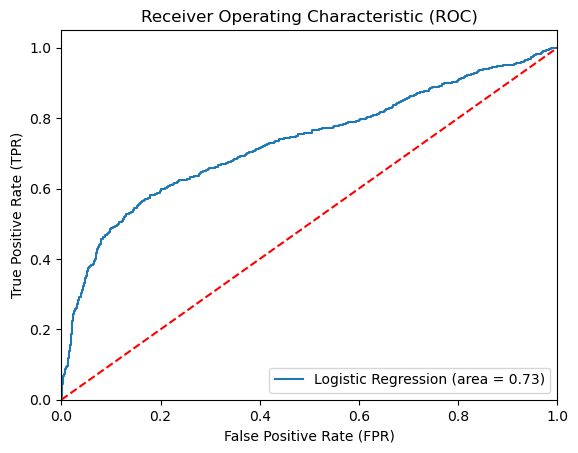

Best Hyperparameters: {'C': 0.02125625682310335, 'penalty': 'l1', 'solver': 'saga'} 

Accuracy Score: 0.6791808873720137 

Confusion Matrix:
[[914 384]
 [462 877]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.70      0.68      1298
           1       0.70      0.65      0.67      1339

    accuracy                           0.68      2637
   macro avg       0.68      0.68      0.68      2637
weighted avg       0.68      0.68      0.68      2637



In [31]:
# We have done the Bayes optimisation so we are now able to se:
# 1. Overall performance metrics
# 2. The ROC curve and the AUC

auc_lr               = get_auc_and_plot_roc(y_test = y_test, y_pred_proba = y_pred_proba_lr, model_name = 'Logistic Regression')
acc_lr, cm_lr, cr_lr = get_and_display_performance_metrics(y_test = y_test, y_pred = y_pred_lr)

Explanation: <a class="anchor" id="logistic_regression"></a>

- **Hyperparameter Space**: we defined and perfromed the hyperparameter space using `hyperopt`'s `hp` module. We defined a log-uniform distribution for `C` to explore a wide range of values on a logarithmic scale. We also defined the choices for the `penalty` and `solver` parameters.
- **Objective Function**: we defined an objective function that takes a set of hyperparameters as input, trains a logistic regression model using those hyperparameters, and returns the negative accuracy as the loss. `hyperopt` minimizes the loss, so we return the negative accuracy to ensure that `hyperopt` is maximizing the accuracy.
- **Bayesian Optimization**: we used `hyperopt`'s `fmin` function to perform Bayesian optimization. We used the Tree-structured Parzen Estimator (TPE) as the optimization algorithm and performed evaluations to find the best hyperparameters.
- **Best Hyperparameters**: finally, we extracted the best hyperparameters from the optimization results and trained the logistic regression model using those hyperparameters !

This script now uses Bayesian optimization for hyperparameter tuning, which can potentially find better hyperparameters in fewer iterations compared to grid search.

***

#### Random forest

We are going to process one of the best algo of all the time: the **Random Forest** ([click here for sklearn docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)).

Invented by [Leo Breiman](https://en.wikipedia.org/wiki/Leo_Breiman), it has been proved to be a "swiss knife" algorithm in Machine Learning both for classifications and regression tasks.

In [32]:
# We define the objective function for hyperopt...

def objective(params):
    model  = RandomForestClassifier(**params, random_state = RANDOM_STATE).fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc    = accuracy_score(y_test, y_pred)
    return {'loss': -acc, 'status': STATUS_OK}

# ...and we define the hyperparameter space "dedicated" to Random Forest model.
space = {
    'n_estimators':      hp.choice('n_estimators', range(50, 300)),
    'max_depth':         hp.choice('max_depth', range(1, 20)),
    'min_samples_split': hp.choice('min_samples_split', range(2, 20)),
    'min_samples_leaf':  hp.choice('min_samples_leaf', range(2, 20)),
    'max_features':      hp.choice('max_features', ['auto', 'sqrt', 'log2']),
}

In [33]:
# Run hyperopt optimization for the RF model...

trials = Trials()
best   = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=BAYES_LOOPS, trials=trials)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.55s/trial, best loss: -0.7159651118695487]


In [34]:
# Train the Random Forest model with the best hyperparameters

best_params = {
    'n_estimators':      best['n_estimators'] + 50,
    'max_depth':         best['max_depth'] + 1,
    'min_samples_split': best['min_samples_split'] + 2,
    'min_samples_leaf':  best['min_samples_leaf'] + 1,
    'max_features':     ['auto', 'sqrt', 'log2'][best['max_features']],
}

rf_model        = RandomForestClassifier(**best_params, random_state=RANDOM_STATE).fit(X_train_scaled, y_train)
y_pred_rf       = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

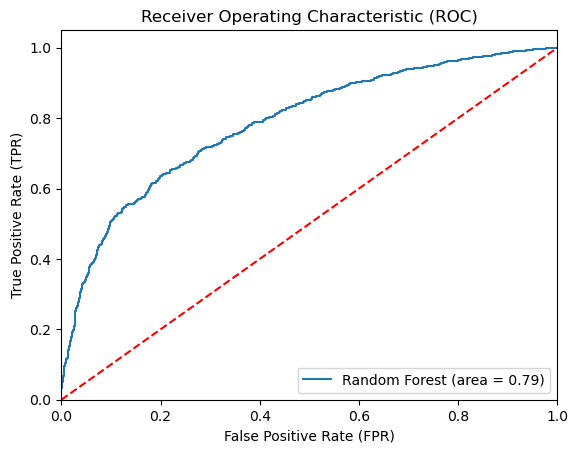

Best Hyperparameters: {'n_estimators': 280, 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 7, 'max_features': 'sqrt'} 

Accuracy Score: 0.7136897990140311 

Confusion Matrix:
[[1042  256]
 [ 499  840]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.80      0.73      1298
           1       0.77      0.63      0.69      1339

    accuracy                           0.71      2637
   macro avg       0.72      0.72      0.71      2637
weighted avg       0.72      0.71      0.71      2637



In [35]:
# We have done the Bayes optimisation so we are now able to see for our new Random Forest:
# 1. Overall performance metrics
# 2. The ROC curve and the AUC

auc_rf               = get_auc_and_plot_roc(y_test = y_test, y_pred_proba = y_pred_proba_rf, model_name = 'Random Forest')
acc_rf, cm_rf, cr_rf = get_and_display_performance_metrics(y_test = y_test, y_pred = y_pred_rf)

Explanation: <a class="anchor" id="random_forest"></a>

- **Random Forest Classifier**: we used now the `RandomForestClassifier` from `scikit-learn` to build and train the random forest model.
- **Hyperparameter Space**: we defined again a space of hyperparameters to search, including the number of estimators, maximum depth of the trees, minimum samples required to split a node, minimum samples required to be at a leaf node, and the number of features to consider when looking for the best split.
- **Objective Function**: we defined an objective function that takes a set of hyperparameters, trains a random forest model, and returns the negative accuracy as the loss to be minimized by `hyperopt`.
- **Bayesian Optimization**: we used `hyperopt` once again to perform Bayesian optimization, using the Tree-structured Parzen Estimator (TPE) algorithm to find the best hyperparameters over all the evaluations steps.
- **Best Hyperparameters**: we extracted the best hyperparameters from the optimization results and trained the random forest model using those hyperparameters.

***

#### Support Vector Machines

SVMs are particolarly suited for modelling *binary classification problems* and adopting the [kernel trick](https://towardsdatascience.com/the-kernel-trick-c98cdbcaeb3f) they are even more powerful on *non linear* problems.

In [36]:
# As already seen, we define the objective function for hyperopt here...

def objective(params):
    model  = SVC(**params, probability=True, random_state=RANDOM_STATE).fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc    = accuracy_score(y_test, y_pred)
    return {'loss': -acc, 'status': STATUS_OK}


space = {
    'C':      hp.loguniform('C', -4, 4),
    'kernel': hp.choice('kernel', ['linear', 'rbf', 'poly', 'sigmoid']),
    'gamma':  hp.choice('gamma',  ['scale', 'auto']),
    'degree': hp.choice('degree', [2, 3, 4, 5, 6]),
}

In [37]:
# We are now familiar somehow with the process, aren't we ?

trials = Trials()
best   = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=BAYES_LOOPS, trials=trials)

best_params = {
    'C':      best['C'],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'][best['kernel']],
    'gamma':  ['scale', 'auto'][best['gamma']],
    'degree': best['degree'] + 2,
}

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [05:06<00:00, 30.67s/trial, best loss: -0.6951080773606371]


In [38]:
svm_model        = SVC(**best_params, probability=True, random_state=RANDOM_STATE).fit(X_train_scaled, y_train)
y_pred_svm       = svm_model.predict(X_test_scaled)
y_pred_proba_svm = svm_model.predict_proba(X_test_scaled)[:, 1]

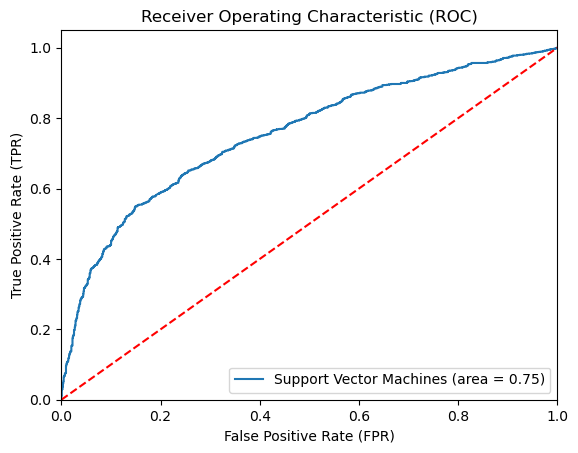

Best Hyperparameters: {'C': 0.21403045664088266, 'kernel': 'rbf', 'gamma': 'auto', 'degree': 4} 

Accuracy Score: 0.6951080773606371 

Confusion Matrix:
[[1091  207]
 [ 597  742]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.84      0.73      1298
           1       0.78      0.55      0.65      1339

    accuracy                           0.70      2637
   macro avg       0.71      0.70      0.69      2637
weighted avg       0.72      0.70      0.69      2637



In [39]:
# We have done the Bayes optimisation so we are now able to see for our new SVM model:
# 1. Overall performance metrics
# 2. The ROC curve and the AUC

auc_svm                 = get_auc_and_plot_roc(y_test = y_test, y_pred_proba = y_pred_proba_svm, model_name = 'Support Vector Machines')
acc_svm, cm_svm, cr_svm = get_and_display_performance_metrics(y_test = y_test, y_pred = y_pred_svm)

Explanation: <a class="anchor" id="svm"></a>

- **Support Vector Machines (SVM)**: we used at this point the `SVC` class from `scikit-learn` to build and train the SVM model.
- **Hyperparameter Space**: we put in place a space of hyperparameters to search, including the regularization parameter `C`, the kernel type, the kernel coefficient `gamma`, and the degree of the polynomial kernel function.
- **Objective Function**: we defined an objective function that takes a set of hyperparameters, trains an SVM model, and returns the negative accuracy as the loss to be minimized by `hyperopt`.
- **Bayesian Optimization**: we used `hyperopt` to perform Bayesian optimization, using the *Tree-structured Parzen Estimator (TPE)* algorithm to find the best hyperparameters over all evaluations.
- **Best Hyperparameters**: we extracted the best hyperparameters from the optimization results and trained the SVM model using those hyperparameters.

***

#### Gradient Boosting Machines

In [40]:
# As done before, let's define the obejctive function for our Gradient Boosting machine !

def objective(params):
    model  = GradientBoostingClassifier(**params, random_state=RANDOM_STATE).fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc    = accuracy_score(y_test, y_pred)
    return {'loss': -acc, 'status': STATUS_OK}


# As seen before, we define here all the possible "variables space" for paramters that GB use...
space = {
    'n_estimators':      hp.choice('n_estimators',      range(50, 301)),
    'max_depth':         hp.choice('max_depth',         range(1, 21)),
    'min_samples_split': hp.choice('min_samples_split', range(2, 21)),
    'min_samples_leaf':  hp.choice('min_samples_leaf',  range(1, 21)),
    'learning_rate':     hp.loguniform('learning_rate', -7, 0),
    'subsample':         hp.uniform('subsample', 0.5, 1.0),
}

In [41]:
# Again, let's run the optimisation process for the gradient boosting machines !

trials = Trials()
best   = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=BAYES_LOOPS, trials=trials)

best_params = {
    'n_estimators':      best['n_estimators'] + 50,
    'max_depth':         best['max_depth'] + 1,
    'min_samples_split': best['min_samples_split'] + 2,
    'min_samples_leaf':  best['min_samples_leaf'] + 1,
    'learning_rate':     best['learning_rate'],
    'subsample':         best['subsample'],
}

gb_model = GradientBoostingClassifier(**best_params, random_state=RANDOM_STATE)
gb_model.fit(X_train_scaled, y_train)

# Let's get our deserved predictions...!

y_pred_gbm       = gb_model.predict(X_test_scaled)
y_pred_proba_gbm = gb_model.predict_proba(X_test_scaled)[:, 1]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:35<00:00,  9.55s/trial, best loss: -0.7110352673492605]


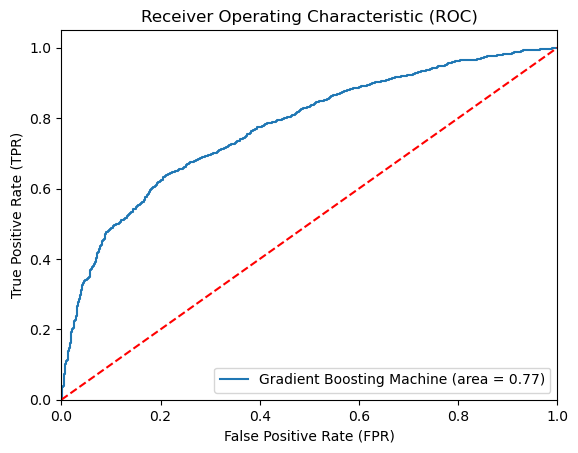

Best Hyperparameters: {'n_estimators': 134, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 7, 'learning_rate': 0.004624922292763074, 'subsample': 0.7279956135928227} 

Accuracy Score: 0.7110352673492605 

Confusion Matrix:
[[1017  281]
 [ 481  858]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.78      0.73      1298
           1       0.75      0.64      0.69      1339

    accuracy                           0.71      2637
   macro avg       0.72      0.71      0.71      2637
weighted avg       0.72      0.71      0.71      2637



In [42]:
# We have done the Bayes optimisation so we are now able to see for our new GBM model:
# 1. Overall performance metrics
# 2. The ROC curve and the AUC

auc_gb               = get_auc_and_plot_roc(y_test = y_test, y_pred_proba = y_pred_proba_gbm, model_name = 'Gradient Boosting Machine')
acc_gb, cm_gb, cr_gb = get_and_display_performance_metrics(y_test = y_test, y_pred = y_pred_gbm)

Explanation: <a class="anchor" id="boosting"></a>

- **Gradient Boosting Classifier**: we used finally the `GradientBoostingClassifier` from `scikit-learn` to build and train the gradient boosting model.
- **Hyperparameter Space**: we defined a space of hyperparameters to search, including the number of boosting stages to be run (`n_estimators`), the maximum depth of the individual estimators, the minimum number of samples required to split an internal node, the minimum number of samples required to be at a leaf node, the learning rate, and the fraction of samples used for fitting the individual base learners.
- **Objective Function**: we defined an objective function that takes a set of hyperparameters, trains a gradient boosting model, and returns the negative accuracy as the loss to be minimized by `hyperopt`.
- **Bayesian Optimization**: we used `hyperopt` to perform Bayesian optimization, using the *Tree-structured Parzen Estimator (TPE)* once more algorithm to find the best hyperparameters over the same all evaluations.
- **Best Hyperparameters**: we extracted the best hyperparameters from the optimization results and trained the gradient boosting model using those hyperparameters.

***

#### Naive Bayes

[Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html) for classification problems is an important toolkit.

In [43]:
# Let's define the objective function for hyperopt here below...

def objective(params):
    
    model  = GaussianNB(**params).fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc    = accuracy_score(y_test, y_pred)
    return {'loss': -acc, 'status': STATUS_OK}

space = {
    'var_smoothing': hp.loguniform('var_smoothing', -10, 0),
}

In [44]:
# Let's run now all the optimisation ofr our "Naive Model"...

trials = Trials()
best   = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=BAYES_LOOPS, trials=trials)

best_params = {
    'var_smoothing': best['var_smoothing'],
}

nb_model = GaussianNB(**best_params).fit(X_train_scaled, y_train)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 187.04trial/s, best loss: -0.6097838452787259]


In [45]:
# As we seen multiple times, let's get out proze :-)

y_pred_nb       = nb_model.predict(X_test_scaled)
y_pred_proba_nb = nb_model.predict_proba(X_test_scaled)[:, 1]

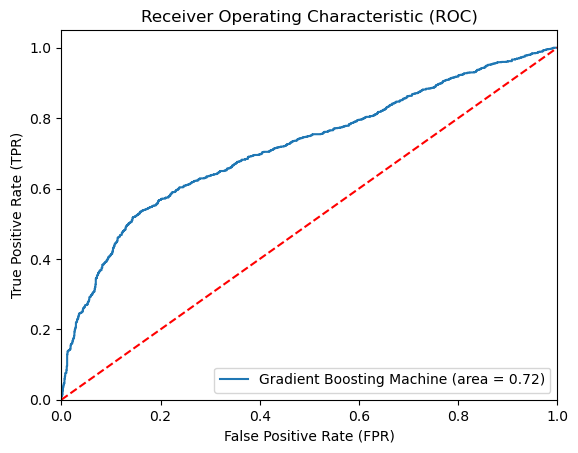

Best Hyperparameters: {'var_smoothing': 0.329168880663775} 

Accuracy Score: 0.6097838452787259 

Confusion Matrix:
[[ 575  723]
 [ 306 1033]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.44      0.53      1298
           1       0.59      0.77      0.67      1339

    accuracy                           0.61      2637
   macro avg       0.62      0.61      0.60      2637
weighted avg       0.62      0.61      0.60      2637



In [46]:
# We have done the Bayes optimisation so we are now able to see for our new Naive Bayes simple model:
# 1. Overall performance metrics
# 2. The ROC curve and the AUC

auc_nb               = get_auc_and_plot_roc(y_test = y_test, y_pred_proba = y_pred_proba_nb, model_name = 'Gradient Boosting Machine')
acc_nb, cm_nb, cr_nb = get_and_display_performance_metrics(y_test = y_test, y_pred = y_pred_nb)

Explanation:

- **Gaussian Naive Bayes**: we used the `GaussianNB` class from `scikit-learn` to build and train the Gaussian Naive Bayes model.
- **Hyperparameter Space**: we defined a space of hyperparameters to search, including the `var_smoothing` parameter, which is a portion of the largest variance of all features added to variances for calculation stability.
- **Objective Function**: we defined an objective function that takes a set of hyperparameters, trains a Naive Bayes model, and returns the negative accuracy as the loss to be minimized by `hyperopt`.
- **Bayesian Optimization**: we used `hyperopt` to perform Bayesian optimization, using the Tree-structured Parzen Estimator (TPE) algorithm to find the best hyperparameters over the total amount of evaluations.
- **Best Hyperparameters**: we extracted the best hyperparameters from the optimization results and trained the Naive Bayes model using those hyperparameters.

***

#### K-Nearest Neighbors

In [47]:
# To consolidate it all once again, let's define our KNN objective function as follows...

def objective(params):
    model  = KNeighborsClassifier(**params).fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc    = accuracy_score(y_test, y_pred)
    return {'loss': -acc, 'status': STATUS_OK}


space = {
    'n_neighbors': hp.choice('n_neighbors', range(1, 50)),
    'weights':     hp.choice('weights', ['uniform', 'distance']),
    'metric':      hp.choice('metric', ['euclidean', 'manhattan', 'minkowski']),
}

In [48]:
# Run bayesian optimisation for our KNN little and effective model ! 

trials = Trials()
best   = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=BAYES_LOOPS, trials=trials)

best_params = {
    'n_neighbors': best['n_neighbors'] + 1,
    'weights':    ['uniform', 'distance'][best['weights']],
    'metric':     ['euclidean', 'manhattan', 'minkowski'][best['metric']],
}

knn_model = KNeighborsClassifier(**best_params).fit(X_train_scaled, y_train)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35trial/s, best loss: -0.6905574516496018]


In [49]:
# Perform predictions with best params ...

y_pred_knn       = knn_model.predict(X_test_scaled)
y_pred_proba_knn = knn_model.predict_proba(X_test_scaled)[:, 1]

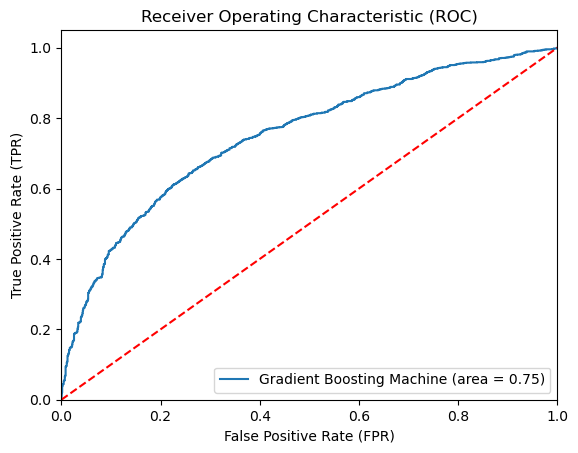

Best Hyperparameters: {'n_neighbors': 24, 'weights': 'distance', 'metric': 'manhattan'} 

Accuracy Score: 0.6905574516496018 

Confusion Matrix:
[[1009  289]
 [ 527  812]] 

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.78      0.71      1298
           1       0.74      0.61      0.67      1339

    accuracy                           0.69      2637
   macro avg       0.70      0.69      0.69      2637
weighted avg       0.70      0.69      0.69      2637



In [50]:
# As seen allover the place, let's obtain for our KNN the followings:
# 1. Overall performance metrics
# 2. The ROC curve and the AUC

auc_knn                 = get_auc_and_plot_roc(y_test = y_test, y_pred_proba = y_pred_proba_knn, model_name = 'Gradient Boosting Machine')
acc_knn, cm_knn, cr_knn = get_and_display_performance_metrics(y_test = y_test, y_pred = y_pred_knn)

Explanation:

- **K-Nearest Neighbors (KNN)**: we used the `KNeighborsClassifier` class from `scikit-learn` to build and train the KNN model.
- **Hyperparameter Space**: we defined a space of hyperparameters to search, including the number of neighbors to use (`n_neighbors`), the weight function used in prediction (`weights`), and the distance metric to use for the tree (`metric`).
- **Objective Function**: we defined an objective function that takes a set of hyperparameters, trains a KNN model, and returns the negative accuracy as the loss to be minimized by `hyperopt`.
- **Bayesian Optimization**: we used `hyperopt` to perform Bayesian optimization, using the Tree-structured Parzen Estimator (TPE) algorithm to find the best hyperparameters overall evaluations.
- **Best Hyperparameters**: we extracted the best hyperparameters from the optimization results and trained the KNN model using those hyperparameters.

***

### Conclusions <a class="anchor" id="conclusions"></a>

We have been applying Logistic Regression, Random Forest, SVM and Gradient Boosting along the way. After each of these models were performed, we collected its **performance metrics** and this is why we can create the following dataframe to collect them all in one point:

In [55]:
models      = ['Logistic Regression', 'Random Forest', 'SVM', 'GBM', 'GaussianNB', 'kNN']
accurancies = [acc_lr, acc_rf, acc_svm, acc_gb, acc_nb, acc_knn]
auc         = [auc_lr, auc_rf, auc_svm, auc_gb, auc_nb, auc_knn]
f1_score    = [cr_lr['macro avg']['f1-score'],
               cr_rf['macro avg']['f1-score'],
               cr_svm['macro avg']['f1-score'],
               cr_gb['macro avg']['f1-score'],
               cr_nb['macro avg']['f1-score'],
               cr_knn['macro avg']['f1-score']]
              

models_perf = pd.DataFrame({'models':      models,
                            'accurancies': accurancies,
                            'auc':         auc,
                            'f1_score':    f1_score})

models_perf.sort_values(['auc', 'accurancies', 'f1_score'], ascending = [False, False, False], inplace = True)
models_perf

,models,accurancies,auc,f1_score
1,Random Forest,0.713690,0.785801,0.712000
3,GBM,0.711035,0.773275,0.709981
2,SVM,0.695108,0.754956,0.689672
5,kNN,0.690557,0.749512,0.688821
0,Logistic Regression,0.679181,0.730389,0.679118
4,GaussianNB,0.609784,0.717729,0.597647


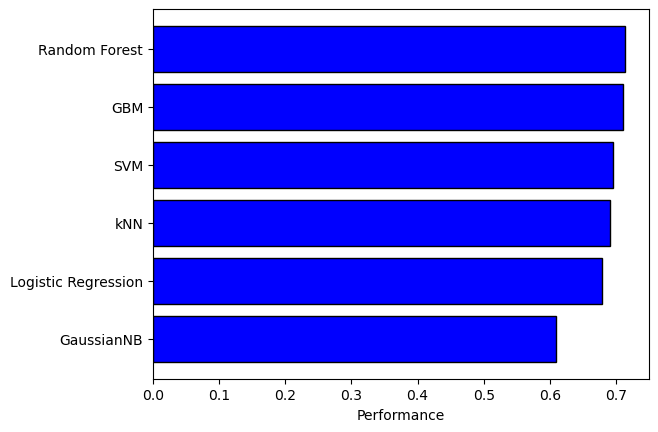

In [76]:
y_pos       = np.arange(len(models))
models_acc  = models_perf
performance = pd.Series(models_acc['accurancies']).sort_values(ascending=0)

plot_hbar_perf_comparison(title         = ''
                          , y_pos       = y_pos
                          , performance = performance
                          , color       = 'blue'
                          , model       = models_acc)

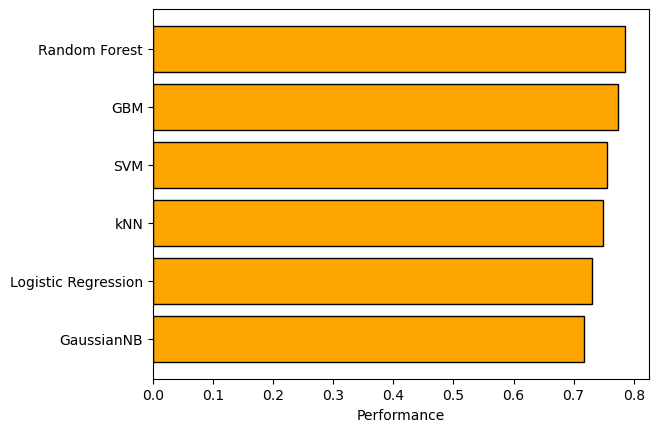

In [77]:
y_pos       = np.arange(len(models))
models_auc  = models_perf
performance = pd.Series(models_acc['auc']).sort_values(ascending=0)

plot_hbar_perf_comparison(title         = ''
                          , y_pos       = y_pos
                          , performance = performance
                          , color       = 'orange'
                          , model       = models_auc)

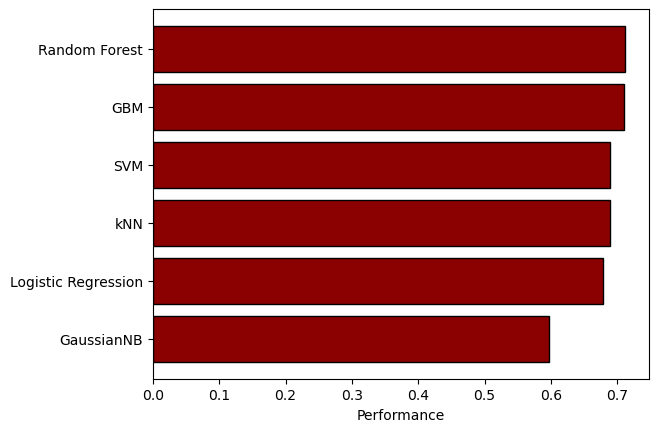

In [78]:
y_pos       = np.arange(len(models))
models_f1   = models_perf
performance = pd.Series(models_acc['f1_score']).sort_values(ascending=0)

plot_hbar_perf_comparison(title         = ''
                          , y_pos       = y_pos
                          , performance = performance
                          , color       = 'darkred'
                          , model       = models_f1)

It is clear that, even if for a small range, on AUC/Accurancy/F1-Score the **Random Forest model is outperforming all the other models.**

One courious note is that **tree algorithms** such as GBM and RandomForest are performing on average quite close meaning that ***they are very well capable in capturing the non linear patterns inside the data.***

Possible future considerations and improvements:
    
1. We performed all the computations on a balanced dataset using **undersampling**: what about SMOTE and oversampling ? What is we will be adding ADASYN, too ? 
2. What if we added neural networks ?
3. It is true that Random Forest is outperforming but, since it has a small yet **very constant** percentage improvement compared to all the models, will it be the case to lose "interpretability" over "performance" ? Logistic Regression could be more easy to explain.

***

### Appendix <a class="anchor" id="appendix"></a>

Very often we do not have all the required time to perform deep dive analysis and we are supposed to search an immediate answer to create a perimeter of possible models to be used around this answer itself.

In this case, the library [lazypredict](https://pypi.org/project/lazypredict/) performs this task letting us to know which are the models we should focus on before actually exploring them in their details (i.e. **performing bayes optmisation to extract best hyperparameter configurations out of them**).

As follows, a simple example on how to use *lazypredict* for our model (nice to see Random Forest is the first model !)

In [87]:
from lazypredict.Supervised import LazyClassifier

X    = credit_data_balanced.drop(columns = ['default']).values
y    = credit_data_balanced['default'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 999)

clf = LazyClassifier(verbose = 0, ignore_warnings = True, custom_metric = None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:21<00:00,  1.37it/s]

[LightGBM] [Info] Number of positive: 3681, number of negative: 3702
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3512
[LightGBM] [Info] Number of data points in the train set: 7383, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498578 -> initscore=-0.005689
[LightGBM] [Info] Start training from score -0.005689
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
RandomForestClassifier             0.72               0.72     0.72      0.71   
LGBMClassifier                     0.71               0.71     0.71      0.71   
ExtraTreesClassifier               0.70               0.70     0.70      0.70   
SVC                                0.70               0.70     0.70      0.70   
AdaBoostClassifier     